In [1]:
!pip -q install torch torchaudio
!pip -q install scikit-learn matplotlib tqdm

In [2]:
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

In [3]:
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS

root = "./data_speechcommands"
os.makedirs(root, exist_ok=True)

In [6]:
!pip -q install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.0 MB/s eta 0:00:00


In [7]:
TARGET_LABELS = ["up", "down", "left", "right"]
label_to_idx = {l: i for i, l in enumerate(TARGET_LABELS)}
idx_to_label = {i: l for l, i in label_to_idx.items()}

train_base = SPEECHCOMMANDS(root, subset="training", download=True)
val_base   = SPEECHCOMMANDS(root, subset="validation", download=True)
test_base  = SPEECHCOMMANDS(root, subset="testing", download=True)

100%|██████████| 2.26G/2.26G [00:24<00:00, 98.7MB/s]


#Filtering

In [8]:
class FilteredSpeechCommands(Dataset):
    def __init__(self, base_ds, allowed_labels, max_items=None, seed=42):
        self.allowed = set(allowed_labels)
        self.idxs = [i for i in range(len(base_ds)) if base_ds[i][2] in self.allowed]
        if max_items is not None and len(self.idxs) > max_items:
            rng = np.random.default_rng(seed)
            self.idxs = rng.choice(self.idxs, size=max_items, replace=False).tolist()

        self.base = base_ds

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        return self.base[self.idxs[i]]

train_set = FilteredSpeechCommands(train_base, TARGET_LABELS, max_items=3000)
val_set   = FilteredSpeechCommands(val_base,   TARGET_LABELS, max_items=3000)
test_set  = FilteredSpeechCommands(test_base,  TARGET_LABELS, max_items=3000)

print("Using labels:", TARGET_LABELS)
print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Using labels: ['up', 'down', 'left', 'right']
Train/Val/Test sizes: 3000 1442 1639


#Creating Spectogram Data

In [9]:
TARGET_SR = 16000
TARGET_LEN = 16000

def pad_or_crop_1d(x, target_len=TARGET_LEN):
    T = x.shape[-1]
    if T == target_len:
        return x
    if T < target_len:
        return F.pad(x, (0, target_len - T))
    return x[:target_len]

N_FFT = 1024
HOP = 512
WIN = 1024

spectrogram_tf=torchaudio.transforms.Spectrogram(n_fft=N_FFT,
                                                 hop_length=HOP,
                                                 win_length=WIN,
                                                 power=2.0,
                                                 center=True)


def make_stft_features(wave_1d):
    """
    wave_1d: (T,) float tensor
    returns: (1, F, TT) log-power spectrogram
    """
    spec = spectrogram_tf(wave_1d.unsqueeze(0))  # (1, F, TT)
    spec = torch.log1p(spec)
    return spec

In [10]:
class SpecDataset(Dataset):
    def __init__(self, base_ds, label_to_idx):
        self.base = base_ds
        self.label_to_idx = label_to_idx
        self.resamplers = {}

    def _resample(self, wav, sr):
        if sr == TARGET_SR:
            return wav
        if sr not in self.resamplers:
            self.resamplers[sr] = torchaudio.transforms.Resample(sr, TARGET_SR)
        return self.resamplers[sr](wav)

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        wav, sr, label, *_ = self.base[idx]  # wav: (1, T)
        wav = self._resample(wav, sr)[0]     # (T,)



        wav = (wav - wav.mean()) / (wav.std() + 1e-6)

        # fixed length
        wav = pad_or_crop_1d(wav, TARGET_LEN)

        # STFT
        spec = make_stft_features(wav)       # (1, F, TT)

        y = self.label_to_idx[label]         # 0..3
        return wav.float(), spec.float(), torch.tensor(y, dtype=torch.long)

train_ds = SpecDataset(train_set, label_to_idx)
val_ds   = SpecDataset(val_set,  label_to_idx)
test_ds  = SpecDataset(test_set,  label_to_idx)

x_raw, x_spec, y = train_ds[0]
print("raw:", x_raw.shape, "spec:", x_spec.shape, "y:", y.item(), idx_to_label[y.item()])

raw: torch.Size([16000]) spec: torch.Size([1, 513, 32]) y: 2 left


In [11]:
BATCH = 128
NUM_WORKERS = 0

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

In [12]:
num_classes = 4

In [13]:
class RawOnlyModel(nn.Module):
    def __init__(self, in_ch=1, n_classes=num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=80, stride=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        self.block4 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Linear(512, n_classes)

    def forward(self, raw, spec):
        x = raw
        if x.dim() == 2:
            x = x.unsqueeze(1)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.flatten(1)
        return self.fc(x)

raw_model = RawOnlyModel(n_classes=num_classes).to(device)
print("Raw Model:")
print(raw_model)

Raw Model:
RawOnlyModel(
  (block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(512, eps=1

In [14]:
class SpecOnlyModel(nn.Module):
    def __init__(self, in_ch=1, n_classes=num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block_custom = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(512, n_classes)

    def forward(self, raw, spec):

        x = spec
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block_custom(x)
        x = self.block4(x)
        x = x.flatten(1)
        return self.fc(x)

spec_model = SpecOnlyModel(n_classes=num_classes).to(device)
print("Updated Spec Model with Batch Normalization:")
print(spec_model)

Updated Spec Model with Batch Normalization:
SpecOnlyModel(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_custom): Sequential(
    (0): Conv2d(128, 256, kernel_

In [15]:
class TwoStreamFusionModel(nn.Module):
    def __init__(self, raw_model, spec_model, num_classes, embedding_dim=128):
        super(TwoStreamFusionModel, self).__init__()
        self.raw_features = nn.Sequential(
            raw_model.block1,
            raw_model.block2,
            raw_model.block3,
            raw_model.block4,
            nn.Flatten()
        )

        self.raw_proj = nn.Linear(512, embedding_dim)
        self.spec_features = nn.Sequential(
            spec_model.block1,
            spec_model.block2,
            spec_model.block3,
            spec_model.block_custom,
            spec_model.block4,
            nn.Flatten()
        )

        self.spec_proj = nn.Linear(512, embedding_dim)
        self.fusion_head = nn.Sequential(
            nn.Linear(embedding_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, raw, spec):
        if raw.dim() == 2:
            raw = raw.unsqueeze(1)
        raw_feat = self.raw_features(raw)
        zr = self.raw_proj(raw_feat)
        spec_feat = self.spec_features(spec)
        zs = self.spec_proj(spec_feat)
        z = torch.cat([zr, zs], dim=1)
        logits = self.fusion_head(z)
        return logits


raw_model_instance = RawOnlyModel(n_classes=4).to(device)
spec_model_instance = SpecOnlyModel(n_classes=4).to(device)
fusion_model = TwoStreamFusionModel(
    raw_model=raw_model_instance,
    spec_model=spec_model_instance,
    num_classes=4,
    embedding_dim=128
).to(device)

print(fusion_model)

TwoStreamFusionModel(
  (raw_features): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,)

In [16]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_y = [], []
    total_loss, total = 0.0, 0

    for raw, spec, y in loader:
        raw, spec, y = raw.to(device), spec.to(device), y.to(device)
        logits = model(raw, spec)
        loss = F.cross_entropy(logits, y)

        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_y.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_y = np.concatenate(all_y)

    acc = (all_preds == all_y).mean()
    macro_f1 = f1_score(all_y, all_preds, average="macro")
    return total_loss/total, acc, macro_f1, all_y, all_preds

def train_model(model, train_loader, val_loader, epochs=15, lr=1e-3, model_name="Model"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    best_val_f1 = -1
    best_state = None
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for ep in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for raw, spec, y in tqdm(train_loader, desc=f"{model_name} Epoch {ep}/{epochs}"):
            raw, spec, y = raw.to(device), spec.to(device), y.to(device)

            opt.zero_grad()
            logits = model(raw, spec)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            opt.step()

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {ep}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_macroF1={val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state:
        model.load_state_dict(best_state)

    return model, history

#Raw Audio Model

In [17]:
# Parameters
LR = 1e-3
TARGET_LABELS = ['left', 'right', 'up', 'down']

# Raw Audio Model
raw_model, raw_hist = train_model(RawOnlyModel(n_classes=4), train_loader, val_loader, 15, LR, "RawOnly")

RawOnly Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=0.9767 | val_loss=1.3920 | val_acc=0.3121 | val_macroF1=0.2302


RawOnly Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6443 | val_loss=0.6479 | val_acc=0.7774 | val_macroF1=0.7664


RawOnly Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5289 | val_loss=0.6727 | val_acc=0.7725 | val_macroF1=0.7655


RawOnly Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4568 | val_loss=0.5686 | val_acc=0.8017 | val_macroF1=0.7960


RawOnly Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.4142 | val_loss=0.5149 | val_acc=0.8162 | val_macroF1=0.8104


RawOnly Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3877 | val_loss=0.5263 | val_acc=0.8391 | val_macroF1=0.8405


RawOnly Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.3534 | val_loss=0.4840 | val_acc=0.8454 | val_macroF1=0.8411


RawOnly Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.3278 | val_loss=0.4229 | val_acc=0.8682 | val_macroF1=0.8684


RawOnly Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.2913 | val_loss=0.6506 | val_acc=0.7926 | val_macroF1=0.7884


RawOnly Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.2542 | val_loss=0.6051 | val_acc=0.7926 | val_macroF1=0.7853


RawOnly Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.2590 | val_loss=0.4252 | val_acc=0.8662 | val_macroF1=0.8668


RawOnly Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.2133 | val_loss=0.5740 | val_acc=0.8010 | val_macroF1=0.7985


RawOnly Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.1769 | val_loss=0.4604 | val_acc=0.8530 | val_macroF1=0.8502


RawOnly Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.1817 | val_loss=0.4889 | val_acc=0.8308 | val_macroF1=0.8334


RawOnly Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.1641 | val_loss=0.6981 | val_acc=0.7587 | val_macroF1=0.7615


# Spectogram and Feature fusion model

In [18]:
# Parameters
EPOCHS = 15
LR = 1e-3
TARGET_LABELS = ['left', 'right', 'up', 'down']

# Spec Model
spec_model, spec_hist = train_model(SpecOnlyModel(n_classes=4), train_loader, val_loader, EPOCHS, LR, "SpecOnly")

# Fusion model
fusion_model, fusion_hist = train_model(TwoStreamFusionModel(raw_model, spec_model, 4), train_loader, val_loader, EPOCHS, LR, "Fusion")

SpecOnly Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=1.0171 | val_loss=3.4526 | val_acc=0.2739 | val_macroF1=0.1293


SpecOnly Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6919 | val_loss=0.7344 | val_acc=0.6935 | val_macroF1=0.6703


SpecOnly Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5842 | val_loss=0.9211 | val_acc=0.6394 | val_macroF1=0.6464


SpecOnly Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4899 | val_loss=0.8439 | val_acc=0.6484 | val_macroF1=0.6461


SpecOnly Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3707 | val_loss=0.4589 | val_acc=0.8419 | val_macroF1=0.8430


SpecOnly Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3102 | val_loss=0.3957 | val_acc=0.8467 | val_macroF1=0.8414


SpecOnly Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.2486 | val_loss=0.5512 | val_acc=0.8093 | val_macroF1=0.8067


SpecOnly Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.2097 | val_loss=1.9152 | val_acc=0.4799 | val_macroF1=0.4692


SpecOnly Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.2080 | val_loss=3.3761 | val_acc=0.3675 | val_macroF1=0.2915


SpecOnly Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.1614 | val_loss=0.8333 | val_acc=0.7094 | val_macroF1=0.7119


SpecOnly Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.1411 | val_loss=0.2951 | val_acc=0.9036 | val_macroF1=0.9036


SpecOnly Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.1149 | val_loss=0.4683 | val_acc=0.8460 | val_macroF1=0.8441


SpecOnly Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.0824 | val_loss=0.2269 | val_acc=0.9293 | val_macroF1=0.9292


SpecOnly Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.0647 | val_loss=0.3097 | val_acc=0.8911 | val_macroF1=0.8873


SpecOnly Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.0663 | val_loss=0.4103 | val_acc=0.8578 | val_macroF1=0.8577


Fusion Epoch 1/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4749 | val_loss=0.7999 | val_acc=0.7559 | val_macroF1=0.7517


Fusion Epoch 2/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2: train_loss=0.1489 | val_loss=1.0053 | val_acc=0.7559 | val_macroF1=0.7139


Fusion Epoch 3/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3: train_loss=0.1604 | val_loss=0.9302 | val_acc=0.7684 | val_macroF1=0.7555


Fusion Epoch 4/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1102 | val_loss=0.4221 | val_acc=0.8516 | val_macroF1=0.8577


Fusion Epoch 5/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0965 | val_loss=0.3634 | val_acc=0.8870 | val_macroF1=0.8874


Fusion Epoch 6/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0776 | val_loss=0.3422 | val_acc=0.8967 | val_macroF1=0.8948


Fusion Epoch 7/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0656 | val_loss=0.3612 | val_acc=0.8877 | val_macroF1=0.8906


Fusion Epoch 8/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8: train_loss=0.0540 | val_loss=0.3439 | val_acc=0.8925 | val_macroF1=0.8926


Fusion Epoch 9/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0602 | val_loss=0.5620 | val_acc=0.8287 | val_macroF1=0.8276


Fusion Epoch 10/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10: train_loss=0.1011 | val_loss=0.6403 | val_acc=0.8218 | val_macroF1=0.8090


Fusion Epoch 11/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11: train_loss=0.0615 | val_loss=0.2621 | val_acc=0.9168 | val_macroF1=0.9165


Fusion Epoch 12/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12: train_loss=0.0451 | val_loss=0.2932 | val_acc=0.9105 | val_macroF1=0.9105


Fusion Epoch 13/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13: train_loss=0.0380 | val_loss=0.1323 | val_acc=0.9632 | val_macroF1=0.9632


Fusion Epoch 14/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14: train_loss=0.0201 | val_loss=0.3770 | val_acc=0.8877 | val_macroF1=0.8869


Fusion Epoch 15/15:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15: train_loss=0.0237 | val_loss=0.4407 | val_acc=0.8897 | val_macroF1=0.8904


#Evaluation and Reports

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Val')
    ax1.set_title(f'{model_name} Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Val')
    ax2.set_title(f'{model_name} Accuracy')
    ax2.legend()
    plt.show()

def run_final_evaluation(models_dict, test_loader, target_names):
    results = []

    for name, model in models_dict.items():
        loss, acc, f1, y_true, y_pred = evaluate(model, test_loader)
        results.append({'Model': name, 'Accuracy': acc, 'Macro F1': f1})

        print(f"\n--- {name} Classification Report ---")
        print(classification_report(y_true, y_pred, target_names=target_names))

        # Confusion Matrix
        fig, ax = plt.subplots(figsize=(5, 5))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=target_names, cmap='Blues', ax=ax)
        ax.set_title(f"Confusion Matrix: {name}")
        plt.show()

    return results

def plot_comparison_histogram(results):
    models = [r['Model'] for r in results]
    accs = [r['Accuracy'] for r in results]
    f1s = [r['Macro F1'] for r in results]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, accs, width, label='Accuracy', color='skyblue')
    ax.bar(x + width/2, f1s, width, label='Macro F1', color='salmon')

    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison of All Three Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.show()

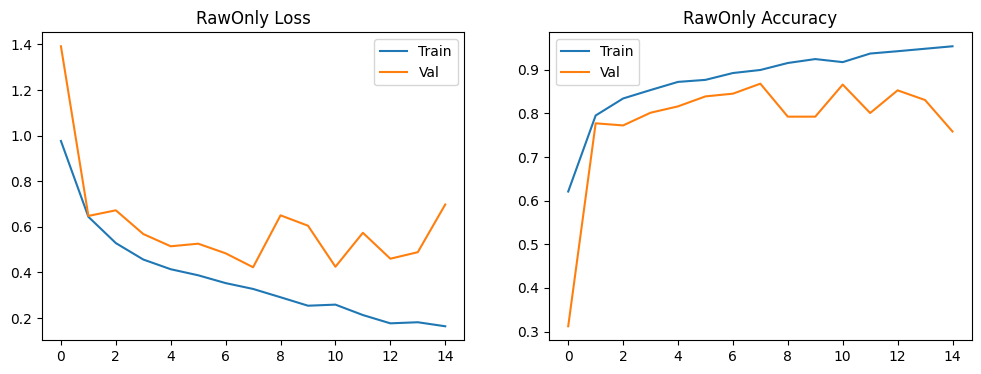

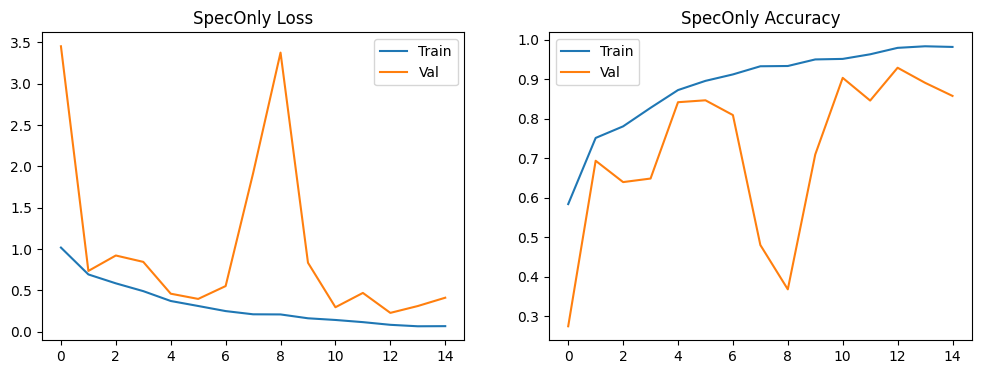

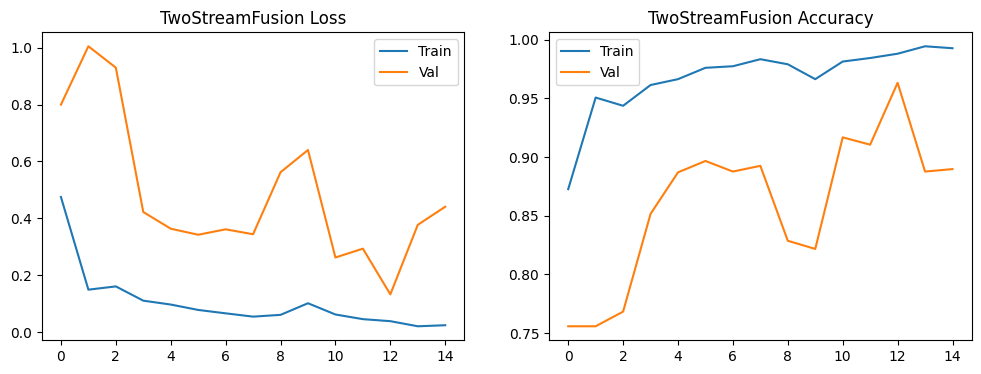

In [20]:

plot_training_history(raw_hist, "RawOnly")
plot_training_history(spec_hist, "SpecOnly")
plot_training_history(fusion_hist, "TwoStreamFusion")


--- Raw Only Classification Report ---
              precision    recall  f1-score   support

        left       0.95      0.73      0.83       425
       right       0.65      0.90      0.76       406
          up       0.76      0.75      0.76       412
        down       0.78      0.68      0.73       396

    accuracy                           0.77      1639
   macro avg       0.79      0.77      0.77      1639
weighted avg       0.79      0.77      0.77      1639



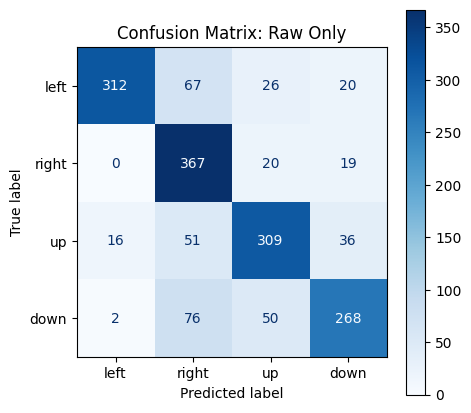


--- Spec Only Classification Report ---
              precision    recall  f1-score   support

        left       0.95      0.92      0.93       425
       right       0.93      0.91      0.92       406
          up       0.94      0.91      0.92       412
        down       0.87      0.95      0.91       396

    accuracy                           0.92      1639
   macro avg       0.92      0.92      0.92      1639
weighted avg       0.92      0.92      0.92      1639



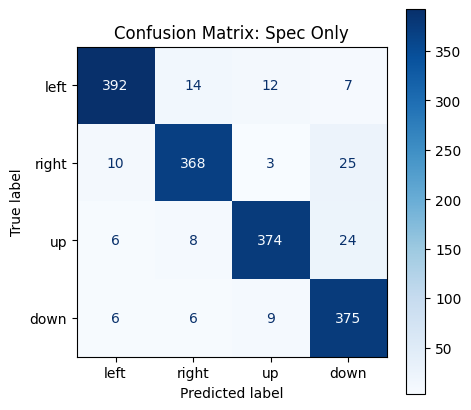


--- Two-Stream Fusion Classification Report ---
              precision    recall  f1-score   support

        left       0.98      0.96      0.97       425
       right       0.89      0.97      0.93       406
          up       0.95      0.93      0.94       412
        down       0.96      0.91      0.93       396

    accuracy                           0.94      1639
   macro avg       0.94      0.94      0.94      1639
weighted avg       0.94      0.94      0.94      1639



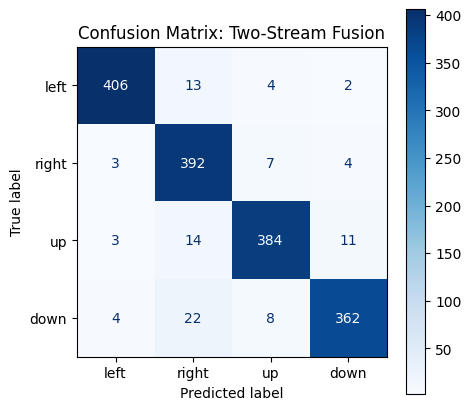

In [21]:
comparison_results = run_final_evaluation(
    {"Raw Only": raw_model, "Spec Only": spec_model, "Two-Stream Fusion": fusion_model},
    test_loader,
    TARGET_LABELS
)

In [22]:
def verify_fusion_logic(model, loader, device):
    model.eval()
    raw, spec, y = next(iter(loader))

    raw = raw.to(device)
    spec = spec.to(device)
    print("\nInput Data Shapes")
    print(f"Raw Signal Batch:   {raw.shape}  (Expected: [Batch, 16000])")
    print(f"Spectrogram Batch:  {spec.shape} (Expected: [Batch, 1, Freq, Time])")

    with torch.no_grad():
        x_raw_input = raw.unsqueeze(1) if raw.dim() == 2 else raw
        raw_feat = model.raw_features(x_raw_input)
        zr = model.raw_proj(raw_feat)
        spec_feat = model.spec_features(spec)
        zs = model.spec_proj(spec_feat)
        print(f"Raw Embedding (zr):  {zr.shape} (Expected: [Batch, emb_dim])")
        print(f"Spec Embedding (zs): {zs.shape} (Expected: [Batch, emb_dim])")
        z = torch.cat([zr, zs], dim=1)
        print(f"Concatenated (z):    {z.shape} (Expected: [Batch, 2 * emb_dim]) ")
        logits = model.fusion_head(z)
        print(f"Final Logits:        {logits.shape} (Expected: [Batch, Num_Classes])")
    input_match = (zr.shape[1] == zs.shape[1])
    concat_match = (z.shape[1] == zr.shape[1] + zs.shape[1])

verify_fusion_logic(fusion_model, train_loader, device)


Input Data Shapes
Raw Signal Batch:   torch.Size([128, 16000])  (Expected: [Batch, 16000])
Spectrogram Batch:  torch.Size([128, 1, 513, 32]) (Expected: [Batch, 1, Freq, Time])
Raw Embedding (zr):  torch.Size([128, 128]) (Expected: [Batch, emb_dim])
Spec Embedding (zs): torch.Size([128, 128]) (Expected: [Batch, emb_dim])
Concatenated (z):    torch.Size([128, 256]) (Expected: [Batch, 2 * emb_dim]) 
Final Logits:        torch.Size([128, 4]) (Expected: [Batch, Num_Classes])
